# MA06129, Bayesian Machine Learning 
by Professor Evgeny Burnaev, E.Burnaev@skoltech.ru
# Homework 5: Problems
Author: Evgenii.Egorov@skoltech.ru

### Intro

We will test different approaches for sampling from "banana" distribution.
You can find animation of sampling from it with Hamiltonian Monte-Carlo <a href="https://chi-feng.github.io/mcmc-demo/app.html#HamiltonianMC,banana">here<a/>

Consider following the transformation of the normal random variable to banana $y$:

\begin{equation*}
\begin{aligned}
& x \sim\mathcal{N}(x|0,\Sigma),~\Sigma = \begin{bmatrix}
1 & \rho \\ 
\rho & 1 
\end{bmatrix}\\
\end{aligned}
\end{equation*}

$$
G(x) = \begin{pmatrix}
x_1 \\ 
x_2 - x_1^2 -1
\end{pmatrix}
$$

$$
y = G(x)
$$

Let's consider $\rho=0.95$. As we know transformation, we can easily sample points from this distribution.

In [57]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
import time
import seaborn as sns

%matplotlib inline

In [2]:
def G(x):
    return np.array([x[:,0], x[:,1] - x[:,0] ** 2 - 1]).T

def sample_banana(base, N):
    x = base.rvs(N) 
    return G(x)

In [3]:
rho = 0.95
base = mvn(mean=np.array([0., 0.]), cov=np.array([[1., rho], [rho, 1.]]))

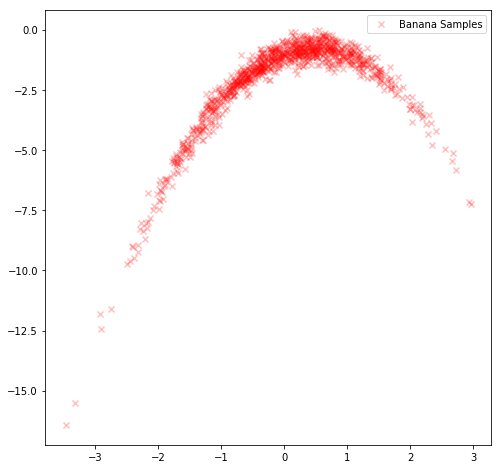

In [4]:
plt.figure(figsize=(8, 8));
S = sample_banana(base, int(1e3));
plt.scatter(x=S[:,0], y=S[:,1], marker='x', color='red', alpha=0.25, label='Banana Samples');
plt.legend();

<a id='problem1'></a>
### Problem 1

As transformation $G$ invertible, we easily derive the analytical form of the $y$ density.  

1. Find the analytical form of $y$ density.
2. Plot level-lines of the density function.


* 2D-distributaion of random variables has the following form:

$$\pi (x_1, x_2) = \frac{1}{2\pi |\Sigma|^{1/2}} \exp \left( -\frac{1}{2}x^T \Sigma^{-1}x \right) =
\frac{1}{2 \pi \sqrt{1 - \rho^2}} \exp \left( \frac{1/2}{\rho^2 - 1} \left( x_1^2 - 2\rho x_1 x_2 + x_2^2 \right) \right) $$

* Change of variables:

$$ P_x(x) = P\left( t(x) \right)  \cdot |\text{ Jacobian } \left( t(x) \right)| $$

$$ P_Y(Y) = P_X \left( G^{-1} (Y) \right) \cdot \det \left( \frac{\partial}{\partial Y} G^{-1} (Y) \right)$$

$$ G^{-1}(Y) = \left( \begin{align} & y_1\\ & y_2 + 1 + y_1^2 \end{align} \right)$$

$$ \det \left( \frac{\partial}{\partial Y} G^{-1} (Y) \right) = \det \left( \begin{align} & 1 & 0\\ & 2y_1 & 1\end{align} \right) = 1 - 0*y_1 $$

$$ P_Y(Y) = \frac{1}{2 \pi \sqrt{1 - \rho^2}} \cdot \exp \left[ - \frac{1}{2(1 - \rho^2)} \left( y_1^2 - 2\rho y_1 (y_1^2 + y_2 +1) + (y_1^2 + y_2 +1)^2  \right) \right]$$

In [61]:
def banana_analytical(y1, y2, p):
    k = 1 - p**2
    x1 = y1
    x2 = y1**2 + y2 + 1
    P_Y = 1 / (2*np.pi*np.sqrt(k)) * np.exp(-(1/(2*k)) * (x1**2 - 2*p*x1*x2 + x2**2))
    return P_Y

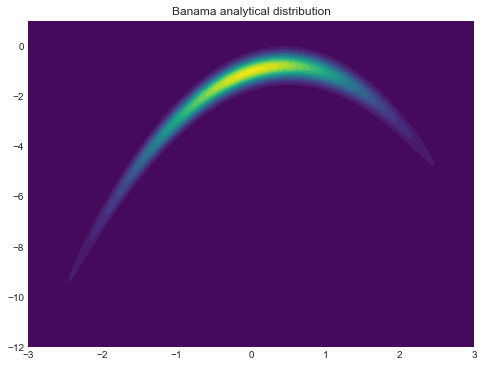

In [71]:
y1 = np.linspace(-3, 3, 2001)
y2 = np.linspace(-12, 1, 2001)
Y1, Y2 = np.meshgrid(y1, y2)

parameter = 0.95
fig = plt.figure(figsize=(8, 6))
P_Y = banana_analytical(Y1, Y2, parameter)

plt.contourf(Y1, Y2, P_Y, 20, cmap=plt.cm.get_cmap('viridis'), origin='lower')
plt.title('Banama analytical distribution')
plt.show()

<a id='problem2'></a>
### Problem 2

Banana distribution is a popular choice for testing MCMC-samplers, because of:
1. Analytical form of banana density is known
2. It has quite complex for MCMC tails

Hence in this task, you are asked to implement Metroposil-Hastings Algorithm and test different proposal distribution to sampling from banana $\pi$.

Consider following proposal distributions:
    
1. $q(x_t|x_{t-1}) = \mathcal{N}\left(x_t|x_{t-1}, \sigma^2 I\right)$
2. $q(x_t|x_{t-1}) = \mathcal{N}\left(x_t|x_{t-1} + \frac{\sigma^2}{2}\nabla\log \pi(x_{t-1}), \sigma I\right)$
3. $q(x_t|x_{t-1}) = \mathcal{N}\left(x_t|x_{t-1} + \nabla\log \pi(x_{t-1}), \left[J(x)^T \Sigma^{-1}J(x)\right]^{-1} \right) + 0.01I$

$$$$

**Solution:**

* grad:

$$ \pi(x_{t-1}) \sim \exp\left[ f(x) \right] $$

$$f(y) = \left[ - \frac{1}{2(1 - \rho^2)} \left( y_1^2 - 2\rho y_1 (y_1^2 + y_2 +1) + (y_1^2 + y_2 +1)^2  \right) \right]$$

$$$$

$$\nabla\log \pi(y_{t-1}) = \frac{\nabla \pi(x_{t-1})}{\pi(x_{t-1}} = \frac{\nabla \pi(x_{t-1})}{\pi(x_{t-1})} = \frac{\pi(x_{t-1}) \cdot\nabla \left[ f(x) \right]}{\pi(x_{t-1})} = \nabla \left[ f(x) \right]  $$

$$ \nabla\log \pi(y_{t-1}) = -\frac{1}{1 - \rho^2} \begin{pmatrix} &2y_1^3 - 3\rho y_1^2 + 3y_1 + 2y_1 y_2 - \rho y_2 \\ & y_1^2 - \rho y_1 + y_2 +1 \end{pmatrix}$$




* Hessian:

$$\nabla^2 \log \pi(y_{t-1}) = -\frac{1}{1 - \rho^2} \begin{pmatrix} 
& 6y_1^2 - 6\rho y_1 + 3 + 2y_2 \quad & 2y_1 - \rho \\
& 2y_1 - \rho & 1\\
\end{pmatrix} $$

#### 2.1 MH-algorithm Implemention.

In [68]:
# def get_Hessian_log(y):
#     H_11 = 6*y[0]**2 - 6*p*y[0] + 3 + 2*y[1]
#     H_12 = 2*y[0] - p
#     H_21 = 2*y[0] - p
#     H_22 = 1
#     Hessian_log = np.matrix([[H_11, H_12], [H_21, H_22]])
#     return (-1/(p**2 - 1))*Hessian_log

def get_grad_log(y):
    grad_1_log = 2*y[0]**3 - 3*parameter*y[0]**2 + 3*y[0] + 2*y[0]*y[1] - parameter*y[1]
    grad_2_log = y[0]**2 - parameter*y[0] + y[1] +1
    grad_log = np.array([grad_1_log, grad_2_log])
    return (1/(parameter**2 - 1))*grad_log

def get_Cov(y):
    J = np.array([[1., 0.], [2*y[0], 1.]])
    Sigma = np.array([[1., p], [p, 1.]])
    Covariance = np.dot((J.T), np.dot(np.linalg.inv(Sigma), J)) + 0.01*np.eye(2)
    return Covariance

def q_1(y_old, sigma):
    q1 = mvn(mean=y_old, cov=(sigma**2)*np.array([[1., 0.], [0., 1.]]))
    return q1

def q_2(y_old, sigma):
    mean = y_old + (sigma**2/2) * get_grad_log(y_old)
    q2 = mvn(mean=mean, cov=(sigma**2)*np.array([[1., 0.], [0., 1.]]))
    return q2
    
def q_3(y_old, sigma):
    mean = y_old + (sigma**2/2) * get_grad_log(y_old)
    cov = get_Cov(y_old)
    q3 = mvn(mean=mean, cov=cov)
    return q3

In [74]:
class MH_sampler:
    def __init__(self, proposal_density, target_density, points, sigma, parameter):
        self.sigma = sigma
        self.proposal_density = proposal_density
        self.target_density = target_density
        self.point = points
        self.count = 0
        self.parameter = parameter
    
    def acceptance_test(self, new_point, old_point):
        p = lambda new_point: self.target_density(new_point[0], new_point[1], 0.95)
        q = lambda new_point, old_point: (self.proposal_density(old_point, self.sigma)).pdf(new_point)
        
        test_result = np.random.uniform() < (p(new_point) * q(new_point, old_point)) / \
                                            (p(old_point) * q(old_point, new_point))
        return test_result
        
    def sample_points(self, N):
        self.point.append(np.zeros(2))
        i = 0    
        while i < N:
            self.count += 1
            y_old = self.point[-1]
            y_new = self.proposal_density(y_old, self.sigma).rvs(1) 
            if self.acceptance_test(y_new, y_old):
                self.point.append(y_new)
                i += 1
        return self.point[-N:], self.count

In [75]:
plots = []
sigmas = np.linspace(0.05, 2.0, 9)

for sigma in sigmas:
    start = time.time()
    Sampler = MH_sampler(q_1, banana_analytical, [], sigma, parameter)
    points, count = Sampler.sample_points(2000)
    end = time.time()
    print ('Sigma =', np.round(sigma, 2), 'Time =', np.round(end - start, 2))
    print ('Number of interations:', count)
    plots.append(np.asarray(points))

Sigma = 0.05 Time = 2.12
Number of interations: 2247
Sigma = 0.29 Time = 3.3
Number of interations: 3740
Sigma = 0.54 Time = 5.21
Number of interations: 5693
Sigma = 0.78 Time = 6.73
Number of interations: 7655
Sigma = 1.02 Time = 9.26
Number of interations: 10609
Sigma = 1.27 Time = 11.53
Number of interations: 13205
Sigma = 1.51 Time = 14.61
Number of interations: 16662
Sigma = 1.76 Time = 17.18
Number of interations: 19705
Sigma = 2.0 Time = 20.46
Number of interations: 23273


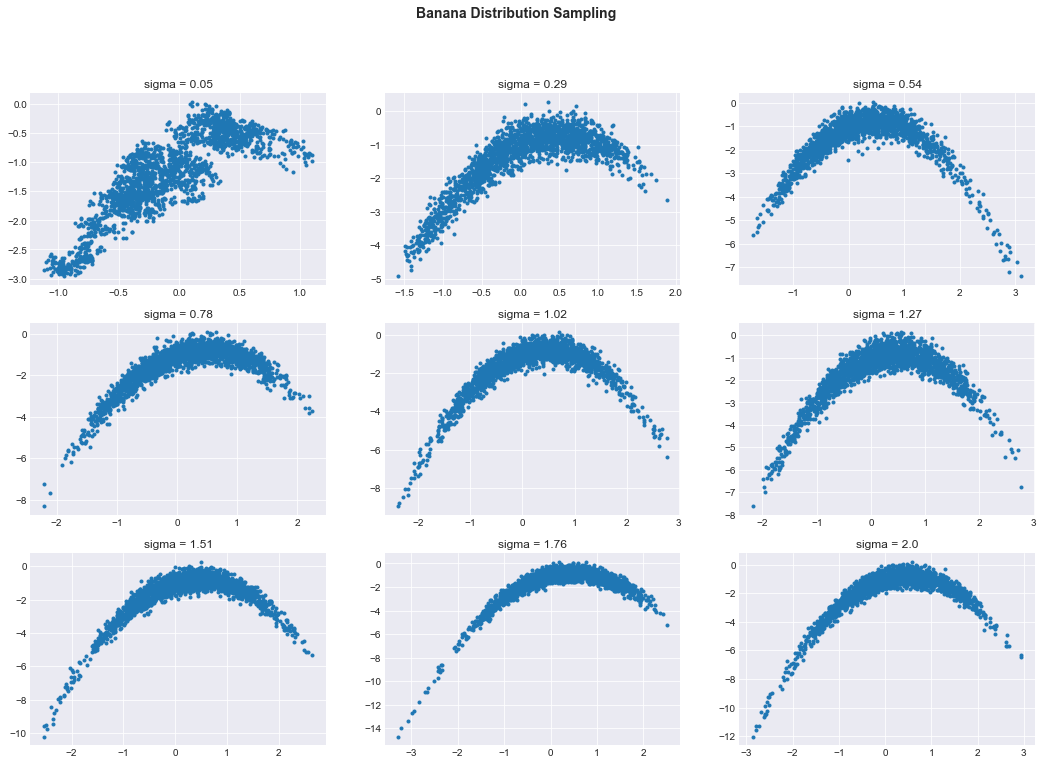

In [77]:
fig = plt.figure(figsize=(18, 12))
fig.suptitle('Banana Distribution Sampling', fontsize=14, fontweight='bold')
sns.set_style("darkgrid")

for i in range (len(sigmas)):
    plt.subplot(3, 3, i+1)
    plt.title('sigma = {}'.format(np.round(sigmas[i], 2)))
    plt.plot(plots[i][:,0], plots[i][:,1], '.')

#### 2.2 Test different proposals

For each proposal we need to do several things:

1. Plot path of dynamics of the sampler over the plot of level-lines of the target density.
2. Estimate acceptance ratio

As it is toy-task, let's consider first $10$ samples as burn-in. 

**Other proposal distributions are very time demading:**

In [205]:
plots_1 = plots.copy()
delta = 0

for sigma in sigmas[4:6]:
    start = time.time()
    Sampler = MH_sampler(q_2, banana_analytical, [], sigma, parameter)
    points, count = Sampler.sample_points(300 - 30*delta)
    delta += 1
    end = time.time()
    
    print ('Sigma =', np.round(sigma, 2), 'Time =', np.round(end - start, 2))
    print ('Number of interations:', count)
    plots_1.append(np.asarray(points))
    
len(plots_1)

Sigma = 0.12 Time = 0.65
Number of interations: 647
Sigma = 0.15 Time = 0.65
Number of interations: 695


6

In [206]:
plots_2 = plots_1

for sigma in sigmas[6:8]:
    start = time.time()
    Sampler = MH_sampler(q_2, banana_analytical, [], sigma, parameter)
    points, count = Sampler.sample_points(200)
    end = time.time()
    
    print ('Sigma =', np.round(sigma, 2), 'Time =', np.round(end - start, 2))
    print ('Number of interations:', count)
    plots_2.append(np.asarray(points))

len(plots_2)

Sigma = 0.18 Time = 0.47
Number of interations: 472
Sigma = 0.2 Time = 1.99
Number of interations: 2120


8

In [209]:
plots_3 = plots_2.copy()

Sampler = MH_sampler(q_2, banana_analytical, [], sigmas[8], parameter)
points, count = Sampler.sample_points(300)
end = time.time()

print ('Sigma =', np.round(sigma, 2), 'Time =', np.round(end - start, 2))
print ('Number of interations:', count)
plots_3.append(np.asarray(points))

Sigma = 0.2 Time = 25.17
Number of interations: 3092


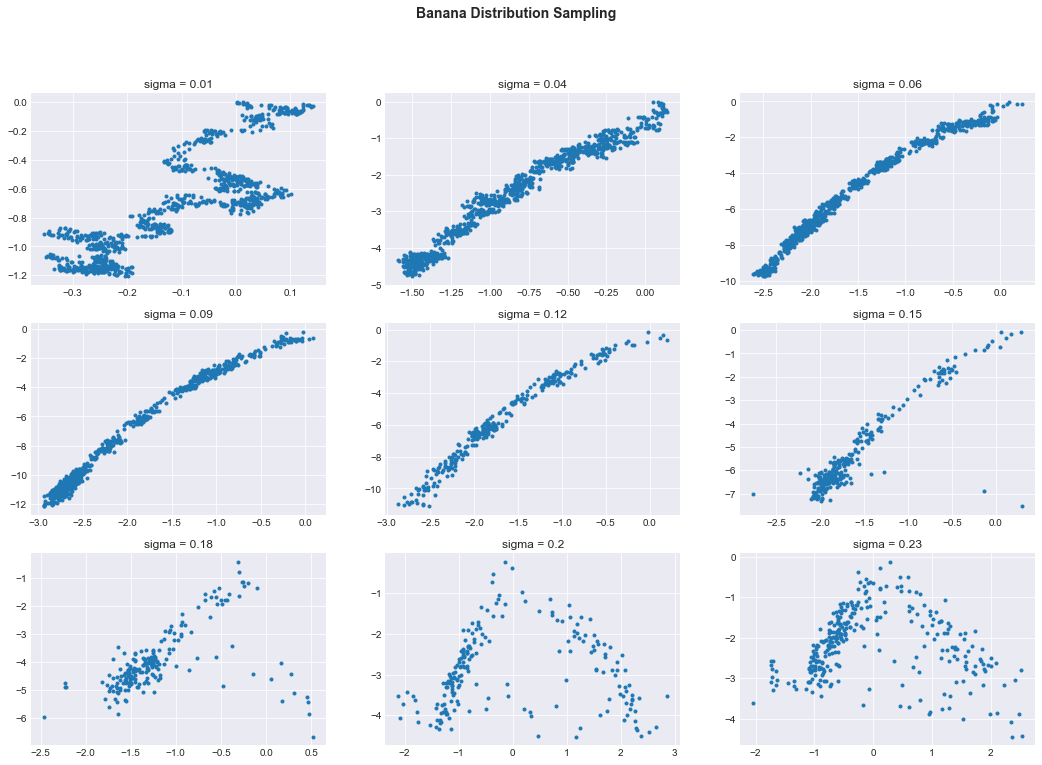

In [210]:
fig = plt.figure(figsize=(18, 12))
fig.suptitle('Banana Distribution Sampling', fontsize=14, fontweight='bold')
sns.set_style("darkgrid")

for i in range (len(plots_3)):
    plt.subplot(3, 3, i+1)
    plt.title('sigma = {}'.format(np.round(sigmas[i], 2)))
    plt.plot(plots_3[i][:,0], plots_3[i][:,1], '.')